In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment


def get_cifar100_datasets(data_dir: str = "./data", val_split: float = 0.0):
    """
    Descarga (si hace falta) y devuelve los datasets de CIFAR-100:
    - train_dataset (o train_rest, val_dataset si val_split > 0)
    - test_dataset

    Args:
        data_dir: carpeta donde se guardan/descargan los datos.
        val_split: proporción del train que se reserva como validación (0.0 = sin validación).

    Returns:
        Si val_split == 0.0:
            train_dataset, None, test_dataset
        Si val_split > 0.0:
            train_dataset, val_dataset, test_dataset
    """

    # Stats típicas de CIFAR-100
    cifar100_mean = (0.5071, 0.4867, 0.4408)
    cifar100_std  = (0.2675, 0.2565, 0.2761)

    train_transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      RandAugment(num_ops=2, magnitude=9),
      transforms.ToTensor(),
      transforms.Normalize(cifar100_mean, cifar100_std),])

    # Transformaciones para test/val (solo resize + normalize)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar100_mean, cifar100_std),])

    # Dataset de training
    full_train_dataset = datasets.CIFAR100(
        root=data_dir,
        train=True,
        download=True,
        transform=train_transform,)

    # Dataset de test
    test_dataset = datasets.CIFAR100(
        root=data_dir,
        train=False,
        download=True,
        transform=test_transform)

    if val_split > 0.0:
        n_total = len(full_train_dataset)
        n_val = int(n_total * val_split)
        n_train = n_total - n_val
        train_dataset, val_dataset = random_split(
            full_train_dataset,
            [n_train, n_val],
            generator=torch.Generator().manual_seed(7))

    else:
        train_dataset = full_train_dataset
        val_dataset = None

    return train_dataset, val_dataset, test_dataset


def get_cifar100_dataloaders(
    batch_size: int = 128,
    data_dir: str = "./data",
    num_workers: int = 2,
    val_split: float = 0.0,
    pin_memory: bool = True):
    """
    Devuelve DataLoaders para CIFAR-100.

    Returns:
        train_loader, val_loader, test_loader
        (val_loader será None si val_split == 0.0)
    """
    train_ds, val_ds, test_ds = get_cifar100_datasets(
        data_dir=data_dir,
        val_split=val_split)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory)


    if val_ds is not None:
        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,)

    else:
        val_loader = None

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory)

    return train_loader, val_loader, test_loader

In [2]:
train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=64,
    data_dir="./data/cifar100",
    num_workers=2,
    val_split=0.1)

100%|██████████| 169M/169M [00:03<00:00, 49.5MB/s] 


In [3]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

images, labels = next(iter(train_loader))

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Images dtype: {images.dtype}, Labels dtype: {labels.dtype}")

Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Images dtype: torch.float32, Labels dtype: torch.int64


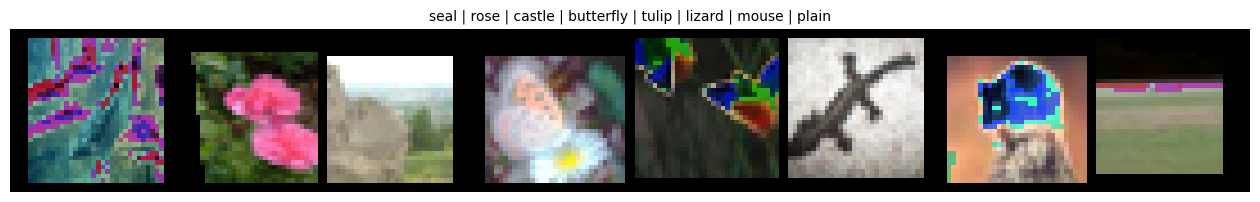

In [4]:
def unnormalize(images: torch.Tensor,
                mean=CIFAR100_MEAN,
                std=CIFAR100_STD):
    """
    Des-normaliza un batch de imágenes.
    images: tensor [B, C, H, W] normalizado.
    """
    mean = torch.tensor(mean, device=images.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=images.device).view(1, -1, 1, 1)
    return images * std + mean


def show_batch(images: torch.Tensor,
               labels: torch.Tensor,
               class_names=None,
               n: int = 8):
    """
    Muestra las primeras n imágenes de un batch con sus labels.

    Args:
        images: tensor [B, C, H, W] (normalizado).
        labels: tensor [B].
        class_names: lista de nombres de clases (len = 100).
        n: cuántas imágenes mostrar (en una fila).
    """
    images = images[:n].cpu()
    labels = labels[:n].cpu()
    images_unnorm = unnormalize(images)

    grid = make_grid(images_unnorm, nrow=n, padding=2)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(2 * n, 2.5))
    plt.imshow(npimg)
    plt.axis("off")

    if class_names is not None:
        title = " | ".join(class_names[int(lbl)] for lbl in labels)
        plt.title(title, fontsize=10)
    plt.show()

cifar100_train = datasets.CIFAR100(
    root="./data/cifar100",
    train=True,
    download=False)
class_names = cifar100_train.classes

show_batch(images, labels, class_names=class_names, n=8)

---

# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbeddingConv(nn.Module):
    """
    Patch embedding estilo Swin.

    - Conv2d con kernel=stride=patch_size para convertir imagen -> grilla de patches.
    - Devuelve el mapa 2D en formato canal-al-final: [B, Hp, Wp, D],
      (más cómodo para window partition).
    - Opcionalmente devuelve tokens [B, N, D].
    - Opcional padding automático si H/W no son divisibles por patch_size.
    """

    def __init__(
        self,
        patch_size: int | tuple[int, int] = 4,
        in_chans: int = 3,
        embed_dim: int = 192,
        norm_layer: type[nn.Module] | None = nn.LayerNorm,
        pad_if_needed: bool = True,
        return_tokens: bool = True):

        super().__init__()

        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)

        self.patch_size = patch_size  # (Ph, Pw)
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.pad_if_needed = pad_if_needed
        self.return_tokens = return_tokens

        # [B, C, H, W] -> [B, D, Hp, Wp]
        self.proj = nn.Conv2d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=True,)

        # En Swin normalmente LayerNorm sobre la última dimensión
        self.norm = norm_layer(embed_dim) if norm_layer is not None else None

    def forward(self, x: torch.Tensor):
        """
        Args:
            x: [B, C, H, W]

        Returns:
            x_map:    [B, Hp, Wp, D]
            (Hp, Wp): tamaño espacial en patches
            x_tokens (opcional): [B, N, D]
            pad_hw (opcional): (pad_h, pad_w) aplicados a la imagen
        """
        B, C, H, W = x.shape
        Ph, Pw = self.patch_size

        pad_h = (Ph - (H % Ph)) % Ph
        pad_w = (Pw - (W % Pw)) % Pw

        if (pad_h != 0 or pad_w != 0):
            if not self.pad_if_needed:
                raise AssertionError(
                    f"Image size ({H}x{W}) no es divisible por patch_size {self.patch_size} "
                    f"y pad_if_needed=False.")

            x = F.pad(x, (0, pad_w, 0, pad_h))

        # [B, D, Hp, Wp]
        x = self.proj(x)
        Hp, Wp = x.shape[2], x.shape[3]

        # canal al final -> [B, Hp, Wp, D]
        x_map = x.permute(0, 2, 3, 1).contiguous()

        if self.norm is not None:
            x_map = self.norm(x_map)

        if self.return_tokens:
            x_tokens = x_map.view(B, Hp * Wp, self.embed_dim)
            return x_map, (Hp, Wp), x_tokens, (pad_h, pad_w)

        return x_map, (Hp, Wp), (pad_h, pad_w)

In [7]:
import torch
import torch.nn.functional as F

def pad_to_window_size(x: torch.Tensor, window_size: int, pad_value: float = 0.0):
    """
    Asegura que H y W sean múltiplos de window_size mediante padding (bottom/right).

    Args:
        x: [B, H, W, C]
        window_size: int
        pad_value: valor de relleno

    Returns:
        x_pad: [B, Hp, Wp, C]
        pad_hw: (pad_h, pad_w)
        orig_hw: (H, W)
    """
    assert x.dim() == 4, "x debe ser [B, H, W, C]"
    B, H, W, C = x.shape

    pad_h = (window_size - (H % window_size)) % window_size
    pad_w = (window_size - (W % window_size)) % window_size

    if pad_h == 0 and pad_w == 0:
        return x, (0, 0), (H, W)

    # F.pad para tensores 4D en este orden: (..., C) => (pad_C_left, pad_C_right, pad_W_left, pad_W_right, pad_H_left, pad_H_right)
    x_pad = F.pad(x, (0, 0, 0, pad_w, 0, pad_h), value=pad_value)
    return x_pad, (pad_h, pad_w), (H, W)

def unpad_from_window_size(x_pad: torch.Tensor, orig_hw: tuple[int, int]):
    """
    Revierte el padding, recortando a (H, W) original.

    Args:
        x_pad: [B, Hp, Wp, C]
        orig_hw: (H, W)

    Returns:
        x: [B, H, W, C]
    """
    H, W = orig_hw
    return x_pad[:, :H, :W, :]

def window_partition(x: torch.Tensor, window_size: int):
    """
    Divide [B, H, W, C] en ventanas no solapadas.

    Args:
        x: [B, H, W, C] con H, W múltiplos de window_size
        window_size: int

    Returns:
        windows: [num_windows * B, window_size, window_size, C]
    """
    assert x.dim() == 4, "x debe ser [B, H, W, C]"

    B, H, W, C = x.shape

    assert H % window_size == 0 and W % window_size == 0, \
        f"H,W deben ser múltiplos de window_size. Got {(H, W)} vs {window_size}"

    x = x.view(B,
        H // window_size, window_size,
        W // window_size, window_size, C)

    # [B, nH, ws, nW, ws, C] -> [B, nH, nW, ws, ws, C] -> [B*nH*nW, ws, ws, C]
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows



def window_reverse(windows: torch.Tensor, window_size: int, H: int, W: int, B: int | None = None):
    """
    Reconstruye [B, H, W, C] a partir de ventanas.

    Args:
        windows: [num_windows * B, window_size, window_size, C]
        window_size: int
        H, W: alto y ancho del mapa (padded) que queremos reconstruir
        B: batch size (si None, se infiere)

    Returns:
        x: [B, H, W, C]
    """
    assert windows.dim() == 4, "windows debe ser [B*nW, ws, ws, C]"
    nBW, ws1, ws2, C = windows.shape
    assert ws1 == window_size and ws2 == window_size

    nH = H // window_size
    nW = W // window_size

    if B is None:
        assert nBW % (nH * nW) == 0, "No puedo inferir B: shapes incompatibles."
        B = nBW // (nH * nW)

    x = windows.view(B, nH, nW, window_size, window_size, C)
    # [B, nH, nW, ws, ws, C] -> [B, nH, ws, nW, ws, C] -> [B, H, W, C]
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, C)
    return x


In [8]:
def cyclic_shift(x: torch.Tensor, shift_size: int | tuple[int, int]):
    """
    Swin usa un shift circular (torch.roll) en H y W.

    Args:
        x: [B, H, W, C]
        shift_size: int o (shift_h, shift_w)
            - shift positivo desplaza hacia abajo/derecha
            - shift negativo hacia arriba/izquierda (lo típico en SW-MSA es negativo)

    Returns:
        x_shifted: [B, H, W, C]
    """
    if isinstance(shift_size, int):
        shift_h, shift_w = shift_size, shift_size
    else:
        shift_h, shift_w = shift_size
    return torch.roll(x, shifts=(shift_h, shift_w), dims=(1, 2))


@torch.no_grad()
def build_shifted_window_attention_mask(
    H: int,
    W: int,
    window_size: int,
    shift_size: int,
    device: torch.device,
    dtype: torch.dtype = torch.float32):
    """
    Crea la máscara que evita que, tras el shift, una ventana atienda a tokens que
    originalmente venían de regiones distintas (bordes "cortados" por el shift).

    Convención:
      - máscara devuelve shape [num_windows, ws*ws, ws*ws]
      - valores: 0 para permitido, -inf (o gran negativo) para bloqueado

    Nota: H y W deben ser múltiplos de window_size (usa pad_to_window_size antes).

    Args:
        H, W: dimensiones (padded)
        window_size: ws
        shift_size: ss (0 < ss < ws)
        device: device
        dtype: dtype (float)

    Returns:
        attn_mask: [num_windows, ws*ws, ws*ws]
    """
    assert 0 < shift_size < window_size, "shift_size debe estar en (0, window_size)."

    img_mask = torch.zeros((1, H, W, 1), device=device, dtype=torch.int64)

    # Dividimos H y W en 3 bandas: [0:-ws], [-ws:-ss], [-ss:]
    h_slices = (slice(0, -window_size),
        slice(-window_size, -shift_size),
        slice(-shift_size, None),)

    w_slices = (slice(0, -window_size),
        slice(-window_size, -shift_size),
        slice(-shift_size, None),)

    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    # Particionamos esa máscara en ventanas
    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.view(-1, window_size * window_size)

    # Diferencias: si id distinto => bloquear atención
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.ne(0)  # bool

    # Convertimos a float con -inf para posiciones bloqueadas
    neg_inf = torch.finfo(dtype).min
    attn_mask = attn_mask.to(dtype) * neg_inf
    return attn_mask

In [9]:
def prepare_windows(
    x: torch.Tensor,
    window_size: int,
    shift_size: int = 0,
    pad_value: float = 0.0):
    """
    Prepara todo lo necesario "antes de la atención":
    - padding a múltiplos de window_size
    - shift opcional (SW-MSA)
    - window_partition
    - attention mask (si shift_size > 0)

    Args:
        x: [B, H, W, C]
        window_size: ws
        shift_size: ss (0 para W-MSA, >0 para SW-MSA)
        pad_value: padding

    Returns:
        windows_flat: [B*num_windows, ws*ws, C]  (listo para entrar a atención)
        meta: dict con info para reconstruir (reverse)
              incluye (Hp, Wp), (H, W), pad_hw, shift_size, attn_mask
    """
    assert x.dim() == 4, "x debe ser [B, H, W, C]"
    B, H, W, C = x.shape
    device = x.device

    x_pad, pad_hw, orig_hw = pad_to_window_size(x, window_size, pad_value=pad_value)
    _, Hp, Wp, _ = x_pad.shape

    attn_mask = None
    if shift_size > 0:
        x_pad = cyclic_shift(x_pad, (-shift_size, -shift_size))  # shift negativo (convención Swin)

        attn_mask = build_shifted_window_attention_mask(
            H=Hp, W=Wp,
            window_size=window_size,
            shift_size=shift_size,
            device=device,
            dtype=torch.float32, )

    # [B*nW, ws, ws, C]
    windows = window_partition(x_pad, window_size)
    # [B*nW, ws*ws, C]  (forma típica para pasar a atención)
    windows_flat = windows.view(-1, window_size * window_size, C)

    meta = {
        "B": B,
        "orig_hw": orig_hw,   # (H, W) original
        "pad_hw": pad_hw,     # (pad_h, pad_w)
        "HpWp": (Hp, Wp),     # (Hp, Wp) padded
        "window_size": window_size,
        "shift_size": shift_size,
        "attn_mask": attn_mask}

    return windows_flat, meta

def restore_from_windows(
    windows_flat: torch.Tensor,
    meta: dict,
    C: int):

    """
    Revierte la preparación:
    - windows_flat -> windows -> window_reverse -> unshift (si aplica) -> unpad

    Args:
        windows_flat: [B*nW, ws*ws, C]
        meta: dict devuelto por prepare_windows
        C: canales

    Returns:
        x: [B, H, W, C] (H,W original)
    """
    B = meta["B"]
    (Hp, Wp) = meta["HpWp"]
    ws = meta["window_size"]
    ss = meta["shift_size"]
    orig_hw = meta["orig_hw"]

    windows = windows_flat.view(-1, ws, ws, C)
    x_pad = window_reverse(windows, ws, Hp, Wp, B=B)

    if ss > 0:
        x_pad = cyclic_shift(x_pad, (ss, ss))  # deshacer shift

    x = unpad_from_window_size(x_pad, orig_hw)
    return x

In [10]:
B, H, W, C = 2, 15, 17, 96
ws = 7
ss = ws // 2

x = torch.randn(B, H, W, C)

# SW-MSA prep
win, meta = prepare_windows(x, window_size=ws, shift_size=ss)
mask = meta["attn_mask"]
print(win.shape)      # [B*nW, ws*ws, C]
print(mask.shape)     # [nW, ws*ws, ws*ws]  (si ss>0)

# "Simulamos" salida de atención: misma forma
y = win.clone()

# Reverse
x_rec = restore_from_windows(y, meta, C=C)
print(x_rec.shape)    # [B, H, W, C]

torch.Size([18, 49, 96])
torch.Size([9, 49, 49])
torch.Size([2, 15, 17, 96])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WindowAttention(nn.Module):
    """
    Window Multi-Head Self-Attention (W-MSA / SW-MSA).

    Entrada:
      x: [B*nW, N, C]  donde N = ws*ws
      mask (opcional): [nW, N, N] con 0 permitido y -inf bloqueado (tu máscara Swin)
    """

    def __init__(
        self,
        dim: int,
        window_size: int,
        num_heads: int,
        qkv_bias: bool = True,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        use_rel_pos_bias: bool = True):

        super().__init__()
        assert dim % num_heads == 0, "dim debe ser múltiplo de num_heads"

        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.use_rel_pos_bias = use_rel_pos_bias

        self.qkv = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_dropout)

        if use_rel_pos_bias:
            ws = window_size
            num_rel = (2 * ws - 1) * (2 * ws - 1)
            self.rel_pos_bias_table = nn.Parameter(torch.zeros(num_rel, num_heads))

            # índice relativo [N, N] para mapear pares (i,j) -> entrada en la tabla
            coords_h = torch.arange(ws)
            coords_w = torch.arange(ws)
            coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            coords_flat = coords.flatten(1)
            rel_coords = coords_flat[:, :, None] - coords_flat[:, None, :]
            rel_coords = rel_coords.permute(1, 2, 0).contiguous()
            rel_coords[:, :, 0] += ws - 1
            rel_coords[:, :, 1] += ws - 1
            rel_coords[:, :, 0] *= (2 * ws - 1)
            rel_pos_index = rel_coords.sum(-1)  #
            self.register_buffer("rel_pos_index", rel_pos_index, persistent=False)

            nn.init.trunc_normal_(self.rel_pos_bias_table, std=0.02)

    def forward(self, x: torch.Tensor, mask: torch.Tensor | None = None):
        """
        x: [BnW, N, C]
        mask: [nW, N, N] float con 0 / -inf
        """
        BnW, N, C = x.shape

        qkv = self.qkv(x)
        qkv = qkv.view(BnW, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        if self.use_rel_pos_bias:
            rel_bias = self.rel_pos_bias_table[self.rel_pos_index.view(-1)]
            rel_bias = rel_bias.view(N, N, self.num_heads).permute(2, 0, 1).contiguous()
            attn = attn + rel_bias.unsqueeze(0)

        if mask is not None:
            # mask: [nW, N, N] -> se aplica por ventana compartir en batch
            nW = mask.shape[0]
            assert BnW % nW == 0, "BnW debe ser múltiplo de nW para aplicar máscara Swin."

            B = BnW // nW

            attn = attn.view(B, nW, self.num_heads, N, N)
            attn = attn + mask.unsqueeze(0).unsqueeze(2)
            attn = attn.view(BnW, self.num_heads, N, N)

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(BnW, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out


In [12]:
torch.manual_seed(0)

B, H, W, C = 2, 15, 17, 96
ws = 7
ss = ws // 2
num_heads = 3

x = torch.randn(B, H, W, C)

attn = WindowAttention(dim=C, window_size=ws, num_heads=num_heads,
                       attn_dropout=0.0, proj_dropout=0.0, use_rel_pos_bias=True)

#  W-MSA (sin shift, sin máscara)
win_w, meta_w = prepare_windows(x, window_size=ws, shift_size=0)
y_w = attn(win_w, mask=meta_w["attn_mask"])

print("W-MSA windows in :", win_w.shape)     # [B*nW, ws*ws, C]
print("W-MSA windows out:", y_w.shape)       # misma shape
assert y_w.shape == win_w.shape

#  SW-MSA (con shift + máscara)
win_sw, meta_sw = prepare_windows(x, window_size=ws, shift_size=ss)
mask = meta_sw["attn_mask"]
y_sw = attn(win_sw, mask=mask)

print("SW-MSA windows in :", win_sw.shape)
print("SW-MSA mask       :", None if mask is None else mask.shape)  # [nW, N, N]
print("SW-MSA windows out:", y_sw.shape)
assert y_sw.shape == win_sw.shape
assert mask is not None and mask.ndim == 3

# mask sanity: debe tener 0 y valores muy negativos
m_min = float(mask.min())
m_max = float(mask.max())
print("Mask min/max:", m_min, m_max)
assert m_max == 0.0, "La máscara Swin debe tener 0 en posiciones permitidas."
assert m_min < -1e20, "La máscara debería tener valores muy negativos (-inf aprox)."

#  grad sanity
win_sw.requires_grad_(True)
y = attn(win_sw, mask=mask)
loss = y.mean()
loss.backward()
g = win_sw.grad
print("Grad ok?  finite:", torch.isfinite(g).all().item(), " mean|g|:", g.abs().mean().item())
assert torch.isfinite(g).all(), "Gradientes no finitos."

print("Sanity check WindowAttention OK")

W-MSA windows in : torch.Size([18, 49, 96])
W-MSA windows out: torch.Size([18, 49, 96])
SW-MSA windows in : torch.Size([18, 49, 96])
SW-MSA mask       : torch.Size([9, 49, 49])
SW-MSA windows out: torch.Size([18, 49, 96])
Mask min/max: -3.4028234663852886e+38 -0.0
Grad ok?  finite: True  mean|g|: 3.2663756428519264e-06
Sanity check WindowAttention OK


In [13]:
import torch
import torch.nn as nn


class DropPath(nn.Module):
    """Stochastic Depth (por muestra)."""
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x: torch.Tensor):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1.0 - self.drop_prob
        # shape: [B, 1, 1, 1] para [B,H,W,C]
        shape = (x.shape[0],) + (1,) * (x.dim() - 1)
        rand = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        mask = torch.floor(rand)
        return x / keep_prob * mask


class MLP(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Bloque Swin completo (pre-norm) en formato [B, H, W, C].

    Usa:
      - prepare_windows(x, window_size, shift_size) -> (windows_flat, meta)
      - restore_from_windows(windows_flat, meta, C) -> x_rec
      - WindowAttention(dim, window_size, num_heads)(windows_flat, mask)
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: int = 7,
        shift_size: int = 0,
        mlp_ratio: float = 4.0,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        mlp_dropout: float = 0.0,
        drop_path: float = 0.0,
        use_rel_pos_bias: bool = True):

        super().__init__()
        assert 0 <= shift_size < window_size, "shift_size debe estar en [0, window_size)"
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)

        self.attn = WindowAttention(
            dim=dim,
            window_size=window_size,
            num_heads=num_heads,
            qkv_bias=True,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
            use_rel_pos_bias=use_rel_pos_bias,)

        self.drop_path1 = DropPath(drop_path)

        self.norm2 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(dim=dim, hidden_dim=hidden_dim, dropout=mlp_dropout)
        self.drop_path2 = DropPath(drop_path)

    def forward(self, x: torch.Tensor):
        """
        x: [B, H, W, C]
        """
        B, H, W, C = x.shape
        assert C == self.dim, f"Canales C={C} != dim={self.dim}"
        assert H >= self.window_size and W >= self.window_size, \
            f"H,W deben ser >= window_size ({self.window_size}). Got {(H, W)}."

        #  Window Attention
        shortcut = x
        x_norm = self.norm1(x)

        windows_flat, meta = prepare_windows(
            x_norm,
            window_size=self.window_size,
            shift_size=self.shift_size,
            pad_value=0.0)

        attn_mask = meta["attn_mask"]  # None o [nW, N, N] con 0/-inf

        out_windows = self.attn(windows_flat, mask=attn_mask)  # [B*nW, N, C]
        x_attn = restore_from_windows(out_windows, meta, C=C)  # [B, H, W, C]

        x = shortcut + self.drop_path1(x_attn)

        # MLP
        x = x + self.drop_path2(self.mlp(self.norm2(x)))

        return x


In [14]:
torch.manual_seed(0)
x = torch.randn(2, 15, 17, 96)

blk = SwinTransformerBlock(dim=96, num_heads=3, window_size=7, shift_size=3,
                           attn_dropout=0.0, proj_dropout=0.0, mlp_dropout=0.0, drop_path=0.0)

y = blk(x)
print(x.shape, y.shape)
assert y.shape == x.shape
print("SwinTransformerBlock OK")

torch.Size([2, 15, 17, 96]) torch.Size([2, 15, 17, 96])
SwinTransformerBlock OK


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchMerging(nn.Module):
    """
    Patch Merging (Swin): [B, H, W, C] -> [B, H/2, W/2, 2C]

    Pasos:
      1) (opcional) pad si H o W es impar
      2) agrupa 2x2 tokens y concatena canales -> 4C
      3) LayerNorm(4C)
      4) Linear(4C -> 2C)
    """

    def __init__(self, dim: int, out_dim: int | None = None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.out_dim = out_dim if out_dim is not None else 2 * dim

        self.norm = norm_layer(4 * dim)
        self.reduction = nn.Linear(4 * dim, self.out_dim, bias=False)

    def forward(self, x: torch.Tensor):
        """
        x: [B, H, W, C]
        """
        assert x.dim() == 4, "x debe ser [B, H, W, C]"
        B, H, W, C = x.shape
        assert C == self.dim, f"C={C} != dim={self.dim}"

        # Pad si H o W es impar (Swin lo hace para poder agrupar 2x2)
        pad_h = H % 2
        pad_w = W % 2
        if pad_h != 0 or pad_w != 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
            H = H + pad_h
            W = W + pad_w

        # Tomar 2x2:
        # x0 = (even rows, even cols), x1 = (odd rows, even cols), x2 = (even rows, odd cols), x3 = (odd rows, odd cols)
        x0 = x[:, 0::2, 0::2, :]  # [B, H/2, W/2, C]
        x1 = x[:, 1::2, 0::2, :]  # [B, H/2, W/2, C]
        x2 = x[:, 0::2, 1::2, :]  # [B, H/2, W/2, C]
        x3 = x[:, 1::2, 1::2, :]  # [B, H/2, W/2, C]

        # Concatenar en canal: [B, H/2, W/2, 4C]
        x = torch.cat([x0, x1, x2, x3], dim=-1)

        # Norm + Linear: [B, H/2, W/2, 2C]
        x = self.norm(x)
        x = self.reduction(x)

        return x

In [16]:
torch.manual_seed(0)
x = torch.randn(2, 15, 17, 96)

pm = PatchMerging(dim=96)
y = pm(x)

print("in :", x.shape)
print("out:", y.shape)

in : torch.Size([2, 15, 17, 96])
out: torch.Size([2, 8, 9, 192])


In [17]:

class BasicLayer(nn.Module):
    """
    Un stage de Swin:
      - depth bloques SwinTransformerBlock
      - alterna shift: 0, ws//2, 0, ws//2, ...
      - downsample opcional al final (PatchMerging) excepto en el último stage
    """
    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: int,
        mlp_ratio: float = 4.0,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        mlp_dropout: float = 0.0,
        drop_path_rates: list[float] | None = None,
        downsample: nn.Module | None = None,
        use_rel_pos_bias: bool = True):

        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.downsample = downsample

        if drop_path_rates is None:
            drop_path_rates = [0.0] * depth
        assert len(drop_path_rates) == depth, "drop_path_rates debe tener longitud = depth"

        blocks = []
        for i in range(depth):
            shift_size = 0 if (i % 2 == 0) else (window_size // 2)
            blocks.append(
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=shift_size,
                    mlp_ratio=mlp_ratio,
                    attn_dropout=attn_dropout,
                    proj_dropout=proj_dropout,
                    mlp_dropout=mlp_dropout,
                    drop_path=drop_path_rates[i],
                    use_rel_pos_bias=use_rel_pos_bias,
                ))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x: torch.Tensor):
        """
        x: [B, H, W, C]
        """
        for blk in self.blocks:
            x = blk(x)

        x_down = None
        if self.downsample is not None:
            x_down = self.downsample(x)
        return x, x_down

In [18]:
import math

class SwinTransformer(nn.Module):
    def __init__(
        self,
        img_size: int | tuple[int, int] = 224,
        patch_size: int = 4,
        in_chans: int = 3,
        num_classes: int = 100,
        embed_dim: int = 96,
        depths: tuple[int, int, int, int] = (2, 2, 6, 2),
        num_heads: tuple[int, int, int, int] = (3, 6, 12, 24),
        window_size: int = 7,
        mlp_ratio: float = 4.0,
        drop_rate: float = 0.0,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        mlp_dropout: float = 0.0,
        drop_path_rate: float = 0.1,
        use_rel_pos_bias: bool = True,):
        super().__init__()

        if isinstance(img_size, int):
            img_h, img_w = img_size, img_size
        else:
            img_h, img_w = img_size

        self.patch_embed = PatchEmbeddingConv(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=nn.LayerNorm,
            pad_if_needed=True,
            return_tokens=False)

        self.pos_drop = nn.Dropout(drop_rate)

        # ---- window_size por stage (clip a la resolución del stage) ----
        Hp = math.ceil(img_h / patch_size)
        Wp = math.ceil(img_w / patch_size)
        stage_res = [(math.ceil(Hp / (2**i)), math.ceil(Wp / (2**i))) for i in range(4)]
        ws = [max(1, min(window_size, h, w)) for (h, w) in stage_res]
        self.window_sizes = tuple(ws)  # para debug
        # ---------------------------------------------------------------

        total_blocks = sum(depths)
        dpr = torch.linspace(0, drop_path_rate, total_blocks).tolist()

        dims = [embed_dim, embed_dim * 2, embed_dim * 4, embed_dim * 8]

        # Stage 1
        self.layer1 = BasicLayer(
            dim=dims[0], depth=depths[0], num_heads=num_heads[0],
            window_size=ws[0], mlp_ratio=mlp_ratio,
            attn_dropout=attn_dropout, proj_dropout=proj_dropout, mlp_dropout=mlp_dropout,
            drop_path_rates=dpr[0:depths[0]],
            downsample=PatchMerging(dim=dims[0], out_dim=dims[1]),
            use_rel_pos_bias=use_rel_pos_bias,)

        # Stage 2
        idx = depths[0]
        self.layer2 = BasicLayer(
            dim=dims[1], depth=depths[1], num_heads=num_heads[1],
            window_size=ws[1], mlp_ratio=mlp_ratio,
            attn_dropout=attn_dropout, proj_dropout=proj_dropout, mlp_dropout=mlp_dropout,
            drop_path_rates=dpr[idx:idx + depths[1]],
            downsample=PatchMerging(dim=dims[1], out_dim=dims[2]),
            use_rel_pos_bias=use_rel_pos_bias,)

        # Stage 3
        idx += depths[1]
        self.layer3 = BasicLayer(
            dim=dims[2], depth=depths[2], num_heads=num_heads[2],
            window_size=ws[2], mlp_ratio=mlp_ratio,
            attn_dropout=attn_dropout, proj_dropout=proj_dropout, mlp_dropout=mlp_dropout,
            drop_path_rates=dpr[idx:idx + depths[2]],
            downsample=PatchMerging(dim=dims[2], out_dim=dims[3]),
            use_rel_pos_bias=use_rel_pos_bias,)

        # Stage 4
        idx += depths[2]
        self.layer4 = BasicLayer(
            dim=dims[3], depth=depths[3], num_heads=num_heads[3],
            window_size=ws[3], mlp_ratio=mlp_ratio,
            attn_dropout=attn_dropout, proj_dropout=proj_dropout, mlp_dropout=mlp_dropout,
            drop_path_rates=dpr[idx:idx + depths[3]],
            downsample=None,
            use_rel_pos_bias=use_rel_pos_bias)

        self.norm = nn.LayerNorm(dims[3])
        self.head = nn.Linear(dims[3], num_classes)

    def forward_features(self, x: torch.Tensor):
        x_map, _, _ = self.patch_embed(x)
        x_map = self.pos_drop(x_map)

        _, x_map = self.layer1(x_map)
        _, x_map = self.layer2(x_map)
        _, x_map = self.layer3(x_map)
        x4, _ = self.layer4(x_map)

        x4 = self.norm(x4)
        x4 = x4.mean(dim=(1, 2))
        return x4

    def forward(self, x: torch.Tensor):
        return self.head(self.forward_features(x))

In [19]:
torch.manual_seed(0)

model = SwinTransformer(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=100,
    embed_dim=96,
    depths=(2, 2, 6, 2),
    num_heads=(3, 6, 12, 24),
    window_size=4,
    drop_path_rate=0.1,)

x = torch.randn(2, 3, 32, 32)
y = model(x)
print(y.shape)  # [2, Clases]

torch.Size([2, 100])


---

In [20]:
import math
import os
import time
import random
import inspect
from contextlib import contextmanager, nullcontext

import torch
import torch.nn as nn
import torch.nn.functional as F

def seed_everything(seed: int = 0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def accuracy_topk(logits: torch.Tensor, targets: torch.Tensor, ks=(1, 3, 5)):
    with torch.no_grad():
        max_k = max(ks)
        B = targets.size(0)
        _, pred = torch.topk(logits, k=max_k, dim=1)
        correct = pred.eq(targets.view(-1, 1).expand_as(pred))
        out = {}
        for k in ks:
            out[k] = 100.0 * correct[:, :k].any(dim=1).float().sum().item() / B
        return out

_DTYPE_MAP = {
    "bf16": torch.bfloat16, "bfloat16": torch.bfloat16,
    "fp16": torch.float16, "float16": torch.float16,
    "fp32": torch.float32, "float32": torch.float32,}


def _cuda_dtype_supported(dtype: torch.dtype) -> bool:
    if not torch.cuda.is_available():
        return False
    return dtype in (torch.bfloat16, torch.float16)


def make_grad_scaler(device: str = "cuda", enabled: bool = True):
    if not enabled:
        return None
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            sig = inspect.signature(torch.amp.GradScaler)
            if len(sig.parameters) >= 1:
                return torch.amp.GradScaler(device if device in ("cuda", "cpu") else "cuda")
            return torch.amp.GradScaler()
        except Exception:
            pass
    if hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "GradScaler"):
        return torch.cuda.amp.GradScaler()
    return None


@contextmanager
def autocast_ctx(device: str = "cuda", enabled: bool = True, dtype: str = "bf16", cache_enabled: bool = True):
    if not enabled:
        with nullcontext():
            yield
        return

    if device == "cuda":
        want = _DTYPE_MAP.get(dtype.lower(), torch.bfloat16)
        use = want if _cuda_dtype_supported(want) else torch.float16
        with torch.amp.autocast(device_type="cuda", dtype=use, cache_enabled=cache_enabled):
            yield
        return

    if device == "cpu":
        try:
            with torch.amp.autocast(device_type="cpu", dtype=torch.bfloat16, cache_enabled=cache_enabled):
                yield
        except Exception:
            with nullcontext():
                yield
        return

    with nullcontext():
        yield


In [21]:
def build_param_groups_no_wd(model: nn.Module, weight_decay: float):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue

        # típicamente no decay en bias y LayerNorm/BatchNorm scale
        if name.endswith(".bias") or ("norm" in name.lower()) or ("bn" in name.lower()) or ("ln" in name.lower()):
            no_decay.append(p)
        else:
            decay.append(p)

    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0}]


class WarmupCosineLR:
    """
    Scheduler simple por STEP:
      - warmup lineal por warmup_steps
      - luego cosine hasta total_steps
    """
    def __init__(self, optimizer, total_steps: int, warmup_steps: int, min_lr: float = 0.0):
        self.optimizer = optimizer
        self.total_steps = int(total_steps)
        self.warmup_steps = int(warmup_steps)
        self.min_lr = float(min_lr)
        self.base_lrs = [g["lr"] for g in optimizer.param_groups]
        self.step_num = 0

    def step(self):
        self.step_num += 1
        t = self.step_num

        for i, group in enumerate(self.optimizer.param_groups):
            base = self.base_lrs[i]
            if t <= self.warmup_steps and self.warmup_steps > 0:
                lr = base * (t / self.warmup_steps)
            else:
                tt = min(t, self.total_steps)
                denom = max(1, self.total_steps - self.warmup_steps)
                progress = (tt - self.warmup_steps) / denom
                cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
                lr = self.min_lr + (base - self.min_lr) * cosine
            group["lr"] = lr

    def state_dict(self):
        return {"step_num": self.step_num}

    def load_state_dict(self, d):
        self.step_num = int(d.get("step_num", 0))


In [22]:
def save_checkpoint(path: str, model, optimizer, scheduler, scaler, epoch: int, best_top1: float, extra: dict | None = None):
    ckpt = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "scaler": scaler.state_dict() if scaler is not None else None,
        "epoch": epoch,
        "best_top1": best_top1,
        "extra": extra or {},}
    torch.save(ckpt, path)


def load_checkpoint(path: str, model, optimizer=None, scheduler=None, scaler=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"], strict=True)
    if optimizer is not None and ckpt.get("optimizer") is not None:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and ckpt.get("scheduler") is not None:
        scheduler.load_state_dict(ckpt["scheduler"])
    if scaler is not None and ckpt.get("scaler") is not None:
        scaler.load_state_dict(ckpt["scaler"])
    return ckpt

In [23]:
def train_one_epoch(
    model: nn.Module,
    dataloader,
    optimizer: torch.optim.Optimizer,
    scheduler,
    device: str = "cuda",
    scaler=None,                       # GradScaler (solo FP16)
    autocast_dtype: str = "fp16",      # "fp16" o "bf16"
    use_amp: bool = True,
    grad_clip_norm: float | None = 1.0,
    label_smoothing: float = 0.1,
    print_every: int = 100,):

    model.train().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    use_scaler = (scaler is not None) and use_amp and autocast_dtype.lower() in ("fp16", "float16")

    running_loss = 0.0
    total = 0
    c1 = c3 = c5 = 0.0

    t0 = time.time()
    for step, (images, targets) in enumerate(dataloader, start=1):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        B = targets.size(0)

        optimizer.zero_grad(set_to_none=True)

        with autocast_ctx(device=device, enabled=use_amp, dtype=autocast_dtype, cache_enabled=True):
            logits = model(images)  # [B, num_classes]

        # LOSS EN FP32 (clave para FP16 estable)
        loss = criterion(logits.float(), targets)

        if use_scaler:
            scaler.scale(loss).backward()
            # para clip hay que unscale primero
            if grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        # metricas
        running_loss += loss.item() * B
        total += B
        accs = accuracy_topk(logits.detach(), targets, ks=(1, 3, 5))
        c1 += accs[1] * B / 100.0
        c3 += accs[3] * B / 100.0
        c5 += accs[5] * B / 100.0

        if print_every and (step % print_every == 0):
            dt = time.time() - t0
            imgs_sec = total / max(dt, 1e-9)
            print(
                f"[train step {step}/{len(dataloader)}] "
                f"loss {running_loss/total:.4f} | "
                f"top1 {100*c1/total:.2f}% | top3 {100*c3/total:.2f}% | top5 {100*c5/total:.2f}% | "
                f"{imgs_sec:.1f} img/s")

    avg_loss = running_loss / total
    metrics = {"top1": 100.0 * c1 / total, "top3": 100.0 * c3 / total, "top5": 100.0 * c5 / total}
    return avg_loss, metrics


@torch.no_grad()
def evaluate_one_epoch(
    model: nn.Module,
    dataloader,
    device: str = "cuda",
    autocast_dtype: str = "fp16",
    use_amp: bool = True,
    label_smoothing: float = 0.1):
    model.eval().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    running_loss = 0.0
    total = 0
    c1 = c3 = c5 = 0.0

    for images, targets in dataloader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        B = targets.size(0)

        with autocast_ctx(device=device, enabled=use_amp, dtype=autocast_dtype, cache_enabled=True):
            logits = model(images)

        loss = criterion(logits.float(), targets)

        running_loss += loss.item() * B
        total += B

        accs = accuracy_topk(logits, targets, ks=(1, 3, 5))
        c1 += accs[1] * B / 100.0
        c3 += accs[3] * B / 100.0
        c5 += accs[5] * B / 100.0

    avg_loss = running_loss / total
    metrics = {"top1": 100.0 * c1 / total, "top3": 100.0 * c3 / total, "top5": 100.0 * c5 / total}
    return avg_loss, metrics

In [24]:
def train_swinvit(
    model: nn.Module,
    train_loader,
    val_loader=None,
    epochs: int = 50,
    device: str = "cuda",
    lr: float = 5e-4,
    weight_decay: float = 0.05,
    autocast_dtype: str = "fp16",   # para A100 usual: "bf16"
    use_amp: bool = True,
    grad_clip_norm: float | None = 1.0,
    warmup_ratio: float = 0.05,     # 5% de steps
    min_lr: float = 0.0,
    label_smoothing: float = 0.1,
    print_every: int = 100,
    save_path: str = "best_swinvit_cifar100.pt",
    resume_path: str | None = None,):

    model.to(device)
    # Optimizer (pro: param groups sin WD en norm/bias)
    param_groups = build_param_groups_no_wd(model, weight_decay=weight_decay)
    optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.999), eps=1e-8)

    # Scheduler warmup + cosine por step
    total_steps = epochs * len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = WarmupCosineLR(optimizer, total_steps=total_steps, warmup_steps=warmup_steps, min_lr=min_lr)

    # AMP scaler: SOLO FP16
    scaler = None
    if use_amp and autocast_dtype.lower() in ("fp16", "float16"):
        scaler = make_grad_scaler(device=device, enabled=True)

    start_epoch = 0
    best_val_top1 = -float("inf")

    if resume_path is not None:
        ckpt = load_checkpoint(resume_path, model, optimizer=optimizer, scheduler=scheduler, scaler=scaler, map_location=device)
        start_epoch = int(ckpt.get("epoch", 0))
        best_val_top1 = float(ckpt.get("best_top1", best_val_top1))
        print(f"Resumed from {resume_path} at epoch {start_epoch} | best_top1 {best_val_top1:.2f}%")

    history = {
        "train_loss": [], "train_top1": [], "train_top3": [], "train_top5": [],
        "val_loss": [], "val_top1": [], "val_top3": [], "val_top5": [],}

    for epoch in range(start_epoch + 1, epochs + 1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")
        t_epoch = time.time()

        tr_loss, tr_m = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            scaler=scaler,
            autocast_dtype=autocast_dtype,
            use_amp=use_amp,
            grad_clip_norm=grad_clip_norm,
            label_smoothing=label_smoothing,
            print_every=print_every,)

        history["train_loss"].append(tr_loss)
        history["train_top1"].append(tr_m["top1"])
        history["train_top3"].append(tr_m["top3"])
        history["train_top5"].append(tr_m["top5"])

        print(f"[Train] loss {tr_loss:.4f} | top1 {tr_m['top1']:.2f}% | top3 {tr_m['top3']:.2f}% | top5 {tr_m['top5']:.2f}%")

        if val_loader is not None:
            va_loss, va_m = evaluate_one_epoch(
                model=model,
                dataloader=val_loader,
                device=device,
                autocast_dtype=autocast_dtype,
                use_amp=use_amp,
                label_smoothing=label_smoothing,)

            history["val_loss"].append(va_loss)
            history["val_top1"].append(va_m["top1"])
            history["val_top3"].append(va_m["top3"])
            history["val_top5"].append(va_m["top5"])

            print(f"[Val]   loss {va_loss:.4f} | top1 {va_m['top1']:.2f}% | top3 {va_m['top3']:.2f}% | top5 {va_m['top5']:.2f}%")

            if va_m["top1"] > best_val_top1:
                best_val_top1 = va_m["top1"]
                save_checkpoint(
                    save_path, model, optimizer, scheduler, scaler,
                    epoch=epoch, best_top1=best_val_top1,
                    extra={"autocast_dtype": autocast_dtype, "use_amp": use_amp},)
                print(f" Best saved to {save_path} (val top1 {best_val_top1:.2f}%)")

        dt = time.time() - t_epoch
        print(f"Epoch time: {dt/60:.2f} min")

    return history

In [27]:
model = SwinTransformer(
    img_size=32,
    patch_size=2,
    in_chans=3,
    num_classes=100,
    embed_dim=96,
    depths=(2, 2, 6, 2),
    num_heads=(3, 6, 12, 24),
    window_size=4,
    drop_path_rate=0.2)

if torch.cuda.device_count() >= 2:
    print('Entrenando en',torch.cuda.device_count(), 'GPUs')
    model = nn.DataParallel(model)   
model = model.to("cuda")

history = train_swinvit(
    model=model, train_loader=train_loader, val_loader=val_loader,
    epochs=50, device="cuda",
    lr=5e-4, weight_decay=0.05,
    autocast_dtype="bf16", use_amp=True,
    grad_clip_norm=1.0,
    save_path="best_swin_cifar100.pt")

Entrenando en 2 GPUs

=== Epoch 1/50 ===
[train step 100/704] loss 4.7562 | top1 1.56% | top3 4.94% | top5 7.67% | 515.4 img/s
[train step 200/704] loss 4.6285 | top1 2.25% | top3 6.60% | top5 10.07% | 517.1 img/s
[train step 300/704] loss 4.5704 | top1 2.77% | top3 7.52% | top5 11.53% | 521.2 img/s
[train step 400/704] loss 4.5192 | top1 3.32% | top3 8.54% | top5 12.98% | 522.4 img/s
[train step 500/704] loss 4.4740 | top1 3.78% | top3 9.73% | top5 14.53% | 524.9 img/s
[train step 600/704] loss 4.4432 | top1 4.04% | top3 10.37% | top5 15.40% | 525.4 img/s
[train step 700/704] loss 4.4105 | top1 4.43% | top3 11.21% | top5 16.59% | 526.9 img/s
[Train] loss 4.4092 | top1 4.44% | top3 11.24% | top5 16.64%
[Val]   loss 4.2126 | top1 5.80% | top3 15.36% | top5 22.26%
 Best saved to best_swin_cifar100.pt (val top1 5.80%)
Epoch time: 1.51 min

=== Epoch 2/50 ===
[train step 100/704] loss 4.1963 | top1 6.94% | top3 17.03% | top5 24.22% | 518.2 img/s
[train step 200/704] loss 4.1798 | top1 7.15